# ORFit Demo


# 0. Imports and Helper Functions

In [1]:
try:
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    print('installing flax')
    %pip install flax
    print('installing augly')
    %pip install augly
    print('installing torchvision')
    %pip install torchvision
    print('installing tqdm')
    %pip install tqdm
    import dynamax
    import flax
    import augly
    import torchvision
    from tqdm import tqdm

/Users/peterchang/Desktop/Repos/dynamax/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [76]:
from typing import Sequence
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
from jax.lax import scan
from jax.lax import cond
from jax.flatten_util import ravel_pytree
import flax.linen as nn

from dynamax.rebayes.utils import MLP, get_mlp_flattened_params
from dynamax.utils import datasets
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.generalized_gaussian_ssm.inference import EKFIntegrals, conditional_moments_gaussian_filter

In [3]:
def plot_rmse(params_history, apply_fn, X, y, ax=None, title=''):
    if ax == None:
        fig, ax = plt.subplots()
    if title == None:
        title = 'RMSE'
    def compute_rmse(params, X, y):
        y_pred = vmap(apply_fn, (None, 0))(params, X)
        return jnp.sqrt(jnp.mean((y_pred - y)**2))
    rmses = vmap(compute_rmse, (0, None, None))(params_history, X, y)
    ax.plot(jnp.arange(len(rmses)), rmses)
    ax.set_title(title);
    return ax

In [151]:
_stable_division = lambda a, b: jnp.where(b.any(), a / b, jnp.zeros(shape=a.shape))
_normalize = lambda v: jnp.where(v.any(), v / jnp.linalg.norm(v), jnp.zeros(shape=v.shape))
_projection_matrix = lambda a: _stable_division(a.reshape(-1, 1) @ a.reshape(1, -1), a.T @ a)
_form_projection_matrix = lambda A: jnp.eye(A.shape[0]) - vmap(_projection_matrix, 1)(A).sum(axis=0)
_project = lambda a, x: _stable_division(a * (a.T @ x), (a.T @ a))
_project_to_columns = lambda A, x: \
    jnp.where(A.any(), vmap(_project, (1, None))(A, x).sum(axis=0), jnp.zeros(shape=x.shape))
_svd = lambda a: jnp.linalg.svd(a, full_matrices=False)

In [134]:
# _project_to_columns(A, jnp.array([1]))

In [35]:
# eps = 1e-5
# _perturb = lambda v: v + eps
# _normalize = lambda v: _perturb(v) / jnp.linalg.norm(_perturb(v))
# _projection_matrix = lambda a: jnp.outer(a, a) / (_perturb(a) @ _perturb(a))
# _project = lambda a, x: _projection_matrix(a) @ x
# _project_to_columns = lambda A, x: \
#     jnp.where(A.any(), vmap(_project, (1, None))(A, x).sum(axis=0), jnp.zeros(shape=x.shape))
# _svd = lambda a: jnp.linalg.svd(a, full_matrices=False)

# 1. ORFit

Orthogonal Recursive Fitting (ORFit) is a memory-efficient approximation to the following exact update rule:

$$\begin{align}
     \tilde{g}_{i-1} &= \nabla \ell_{i}(w_{i-1}) - \sum_{v \in S_{i-1}} \text{proj}_{v}(\nabla \ell_i (w_{i-1})) \\
     S_i &= S_{i-1} \cup \{ \nabla f_i (w_{i-1}) - \sum_{v \in S_{i-1}} \text{proj}_{v}(\nabla f_i (w_{i-1})) \} \\
     w_i &= w_{i-1} - \eta_{i-1} \tilde{g}_{i-1} \\
     \eta_{i-1} &= \frac{f_i(w_{i-1}) - y_i}{\nabla f_i (w_{i-1})^{\intercal} \tilde{g}_{i-1}}
\end{align}$$
where instead of storing all past updates via $S_i$, it uses a rank-$m$ approximation by taking its top $m$ singular values using SVD.

In [153]:
def orthogonal_recursive_fitting(init_params, apply_fn, loss_fn, xs, ys, memory_limit):
    U, Sigma = jnp.zeros((len(init_params), 1)), jnp.array([])
    params = init_params

    params_history = []
    cov_history = []
    for t in range(len(xs)):
        x, y = xs[t], ys[t]
        current_loss_fn = lambda w: loss_fn(w, x, y)
        apply_params_fn = lambda w: apply_fn(w, x)
        g = jacrev(current_loss_fn)(params)
        # print('g: ', g)
        # print('U: ', U)
        f_prime = jacrev(apply_params_fn)(params)
        # print('f_prime: ', f_prime)
        g_tilde = g - _project_to_columns(U, g.ravel())
        # print('g_tilde: ', g_tilde)
        v_prime = f_prime - _project_to_columns(U, f_prime.ravel())
        # print('v_prime: ', v_prime)

        if t <= memory_limit:
            if t == 0:
                U = v_prime.reshape(-1, 1)
            else:
                U = jnp.hstack((U, v_prime.reshape(-1, 1)))
            if t == memory_limit:
                U, Sigma, _ = _svd(U)
        else:
            u = _normalize(v_prime)
            U_tilde, Sigma, _ = _svd(jnp.diag(jnp.append(Sigma, u.ravel() @ v_prime.ravel())))
            U = jnp.hstack((U, u.reshape(-1, 1))) @ U_tilde
            U, Sigma = U[:, :memory_limit], Sigma[:memory_limit]
        eta = _stable_division((apply_params_fn(params) - y), (f_prime.ravel() @ g_tilde.ravel()))
        params = params - eta * g_tilde.ravel()
        cov = _form_projection_matrix(U)
        params_history.append(params)
        cov_history.append(cov)
        # print('\n')
        
    return jnp.array(params_history), jnp.array(cov_history)

In [378]:
# # WIP: more efficient ORFit using lax.scan
# def orthogonal_recursive_fitting(init_params, apply_fn, loss_fn, xs, ys, memory_limit):
#     U, Sigma = jnp.zeros((len(init_params), memory_limit)), jnp.array([])

#     # Common step
#     def _step(carry, t):
#         params, U, Sigma = carry
#         x, y = xs[t], ys[t]
#         current_loss_fn = lambda w: loss_fn(w, x, y)
#         apply_params_fn = lambda w: apply_fn(w, x)
#         g = jacrev(current_loss_fn)(params)
#         v = jacrev(apply_params_fn)(params)
#         g_tilde = g - _project_to_columns(U, g.ravel())
#         v_prime = v - _project_to_columns(U, v.ravel())
    
#     # Step before reaching memory limit
#     def _step_before_limit(carry, t):
#         params, U, Sigma = carry
#         _step(carry, t)
    
#     def _step_after_limit(carry, t):
#         params, U, Sigma = carry
#         _step(carry, t)
        
    
#     params_history, _ = scan(_step, (init_params, U, Sigma), jnp.arange(len(xs)))

#     return params_history

# 2. Demo - Linear Regression

In [39]:
def generate_linreg_dataset(num_points=200, theta=jnp.array([2.5, 0.5]), var=0.01, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [40]:
X_lr, X_lr_sh, Y_lr, Y_lr_sh, Y_lr_tr = generate_linreg_dataset(100)

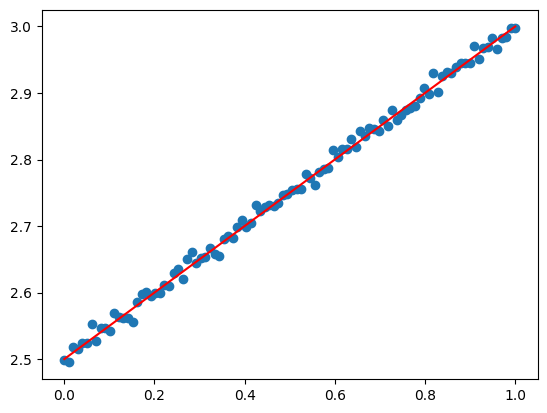

In [41]:
plt.scatter(X_lr, Y_lr)
plt.plot(X_lr, Y_lr_tr, c='red');

In [42]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


In [154]:
# L2 loss
loss_fn_lr = lambda w, x, y: (apply_fn_lr(w, x) - y)**2

# Run ORFit on linreg dataset
history_lr, _ = orthogonal_recursive_fitting(flat_params_lr, apply_fn_lr, loss_fn_lr, X_lr_sh, Y_lr_sh, 100)

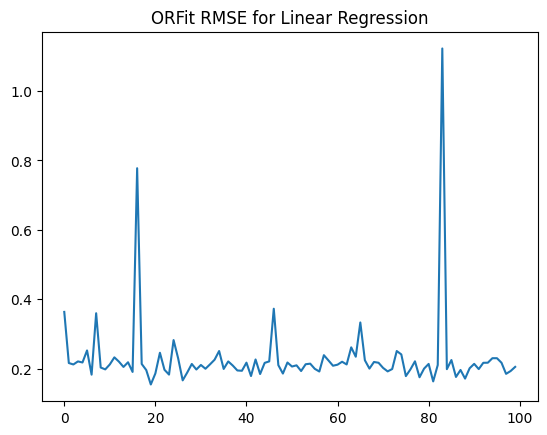

In [46]:
fig, ax = plt.subplots()
plot_rmse(history_lr, apply_fn_lr, X_lr, Y_lr, ax, 'ORFit RMSE for Linear Regression');

# 3. Demo - Nonlinear Regression

In [48]:
def generate_nonlinreg_dataset(num_points=200, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.001, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [49]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

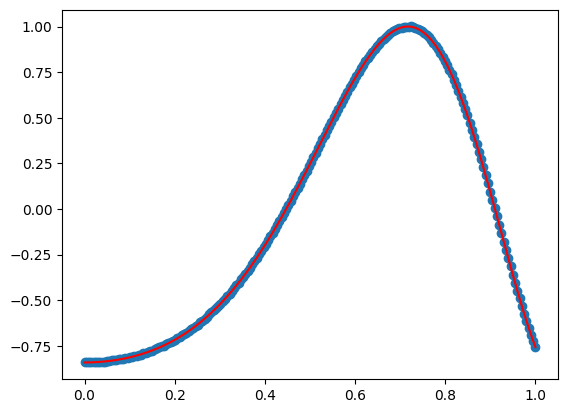

In [50]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

Narrow NN

In [51]:
# Define Non-Linear Regression as MLP with two hidden layers
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [20, 20], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(481,)


In [52]:
# L2 loss
loss_fn_nr = lambda w, x, y: (apply_fn_nr(w, x) - y)**2

# Run ORFit on non-linear dataset
history_nr, _ = orthogonal_recursive_fitting(flat_params_nr, apply_fn_nr, loss_fn_nr, X_nr_sh, Y_nr_sh, 50)

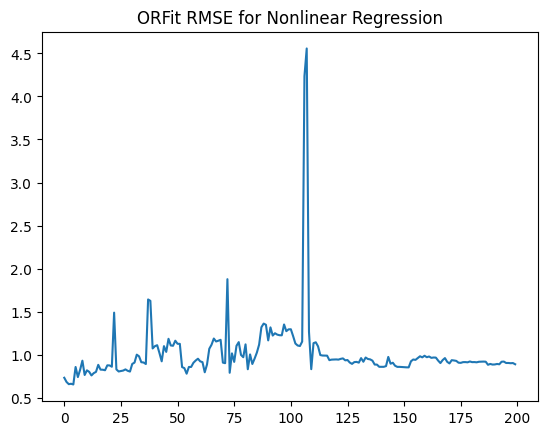

In [53]:
fig, ax = plt.subplots()
plot_rmse(history_nr, apply_fn_nr, X_nr_sh, Y_nr_sh, ax, 'ORFit RMSE for Nonlinear Regression');

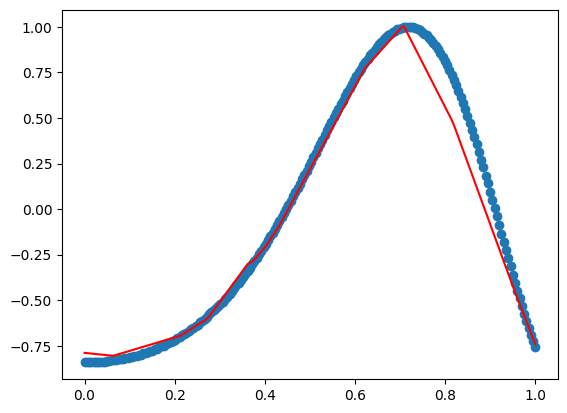

In [54]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, vmap(apply_fn_nr, (None, 0))(history_nr[-1], X_nr), c='red');

NTK Regime: wide NN

In [497]:
# Define Non-Linear Regression as MLP with two hidden layers
input_dim_ntk, hidden_dims_ntk, output_dim_ntk = 1, [1000, 1000,], 1
model_dims_ntk = [input_dim_ntk, *hidden_dims_ntk, output_dim_ntk]
_, flat_params_ntk, _, apply_fn_ntk = get_mlp_flattened_params(model_dims_ntk)
print(flat_params_ntk.shape)

(1004001,)


In [498]:
# L2 loss
loss_fn_ntk = lambda w, x, y: (apply_fn_ntk(w, x) - y)**2

# Run ORFit on non-linear dataset (NTK Regime)
history_ntk = orthogonal_recursive_fitting(flat_params_ntk, apply_fn_ntk, loss_fn_ntk, X_nr_sh, Y_nr_sh, 50)

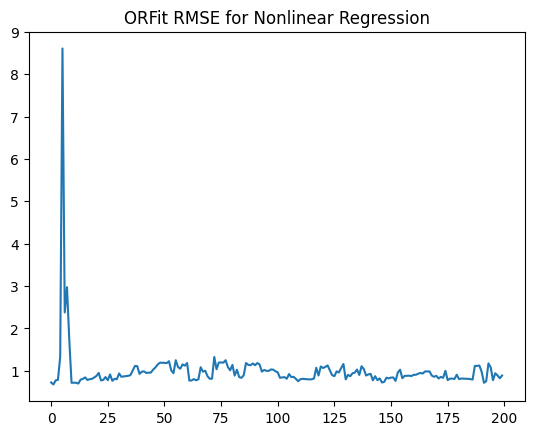

In [499]:
fig, ax = plt.subplots()
plot_rmse(history_ntk, apply_fn_ntk, X_nr_sh, Y_nr_sh, ax, 'ORFit RMSE for Nonlinear Regression');

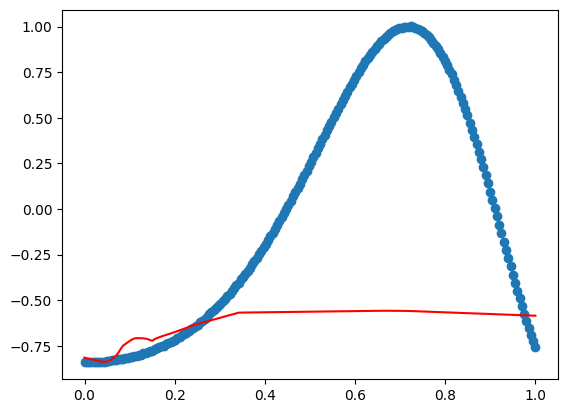

In [500]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, vmap(apply_fn_ntk, (None, 0))(history_ntk[-1], X_nr), c='red');

# 4. Demo - Rotating MNIST

## 4.1 Test Error

In [55]:
# Load rotated MNIST dataset
np.random.seed(314)
num_train = 100

train, test = datasets.load_rotated_mnist(target_digit=2)
X_train, y_train = train
X_test, y_test = test

X_train = jnp.array(X_train)
y_train = jnp.array(y_train)

X_train = jnp.array(X_train)[:num_train]
y_train = jnp.array(y_train)[:num_train]

ix_sort = jnp.argsort(y_train)
X_train_inc = X_train[ix_sort]
y_train_inc = y_train[ix_sort]

In [56]:
X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

X_train_inc = (X_train_inc - X_train_inc.mean()) / X_train_inc.std()

In [57]:
# Define Linear Regression as single layer perceptron
input_dim_rmnist, hidden_dims_rmnist, output_dim_rmnist = 784, [], 1
model_dims_rmnist = [input_dim_rmnist, *hidden_dims_rmnist, output_dim_rmnist]
_, flat_params_rmnist, _, apply_fn_rmnist = get_mlp_flattened_params(model_dims_rmnist)
print(flat_params_rmnist.shape)

# L2 loss
loss_fn_rmnist = lambda w, x, y: (apply_fn_rmnist(w, x) - y)**2

(785,)


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


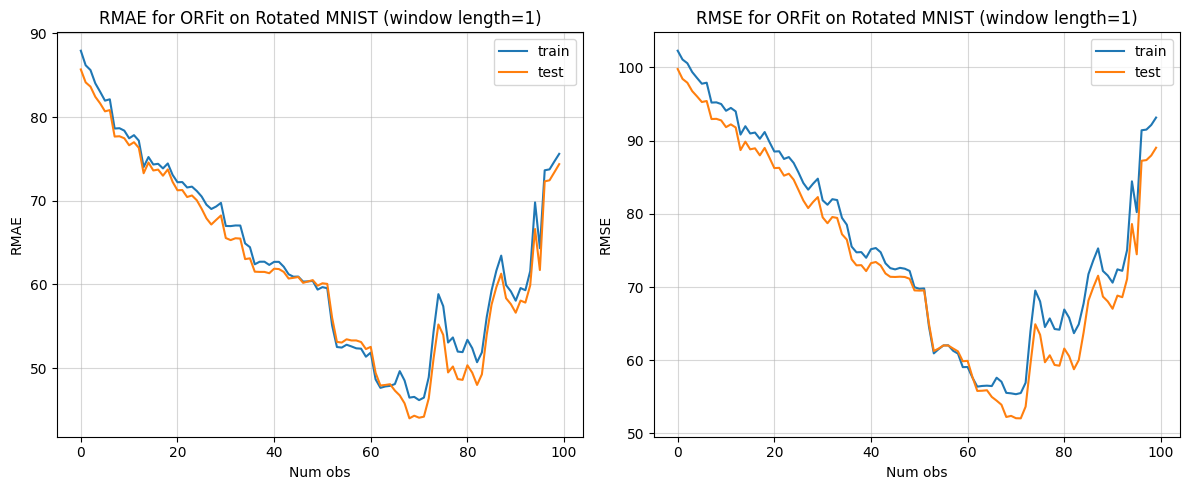

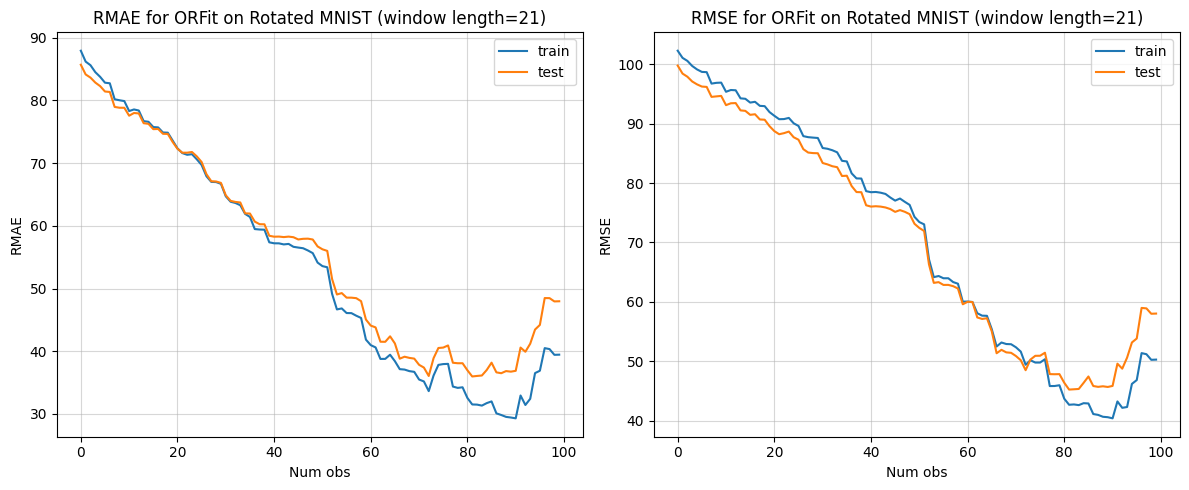

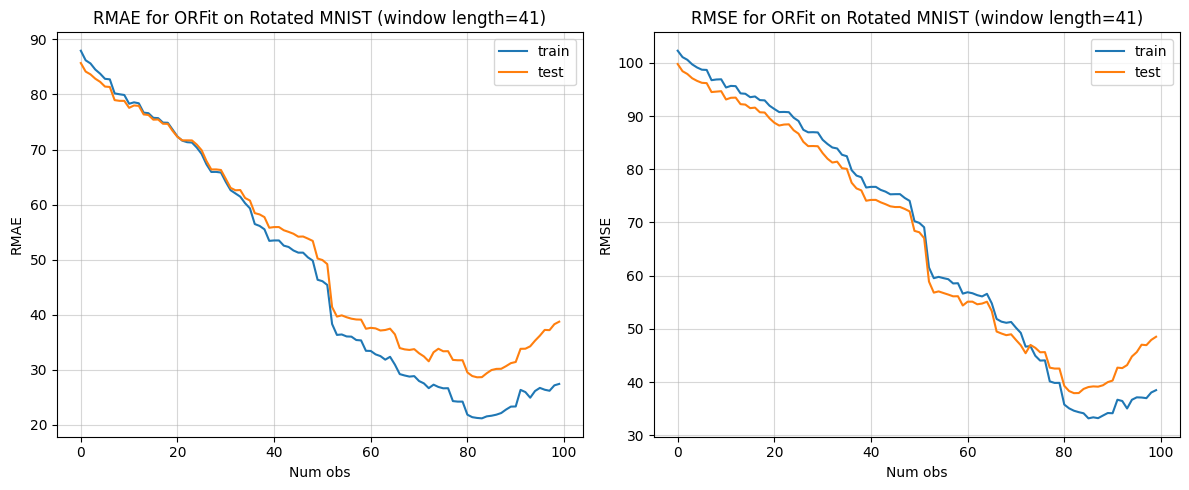

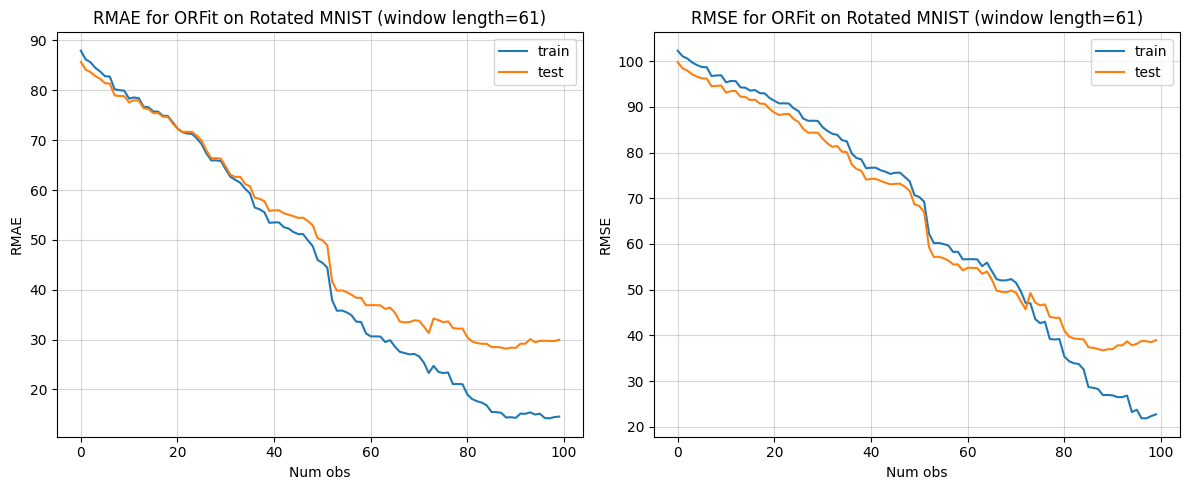

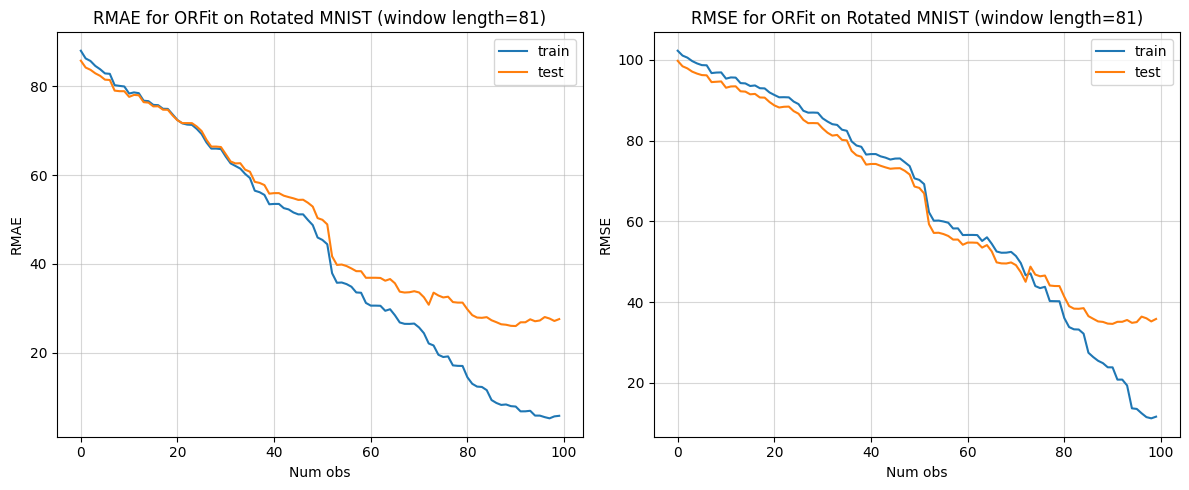

In [93]:
for win_len in tqdm(range(1, 101, 20)):
    # Run ORFit on rmnist dataset
    history_rmnist, _ = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train_inc, y_train_inc, win_len)

    # Predict on train and test set
    yhat_hist_train = vmap(apply_fn_rmnist, (0, None))(history_rmnist, X_train_inc).squeeze()
    yhat_hist_test = vmap(apply_fn_rmnist, (0, None))(history_rmnist, X_test).squeeze()

    rmae_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
    rmae_hist_train = jnp.abs(yhat_hist_train - y_train_inc[None, :]).mean(axis=-1)

    rmse_hist_test = jnp.sqrt(((yhat_hist_test - y_test[None, :])**2).mean(axis=-1))
    rmse_hist_train = jnp.sqrt(((yhat_hist_train - y_train_inc[None, :])**2).mean(axis=-1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(rmae_hist_train, label="train")
    ax1.plot(rmae_hist_test, label="test")
    ax1.legend()
    ax1.set_xlabel("Num obs")
    ax1.set_ylabel("RMAE")
    ax1.set_title(f"RMAE for ORFit on Rotated MNIST (window length={win_len})")
    ax1.grid(alpha=0.5)

    ax2.plot(rmse_hist_train, label="train")
    ax2.plot(rmse_hist_test, label="test")
    ax2.legend()
    ax2.set_xlabel("Num obs")
    ax2.set_ylabel("RMSE")
    ax2.set_title(f"RMSE for ORFit on Rotated MNIST (window length={win_len})")
    ax2.grid(alpha=0.5)

    plt.tight_layout()


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


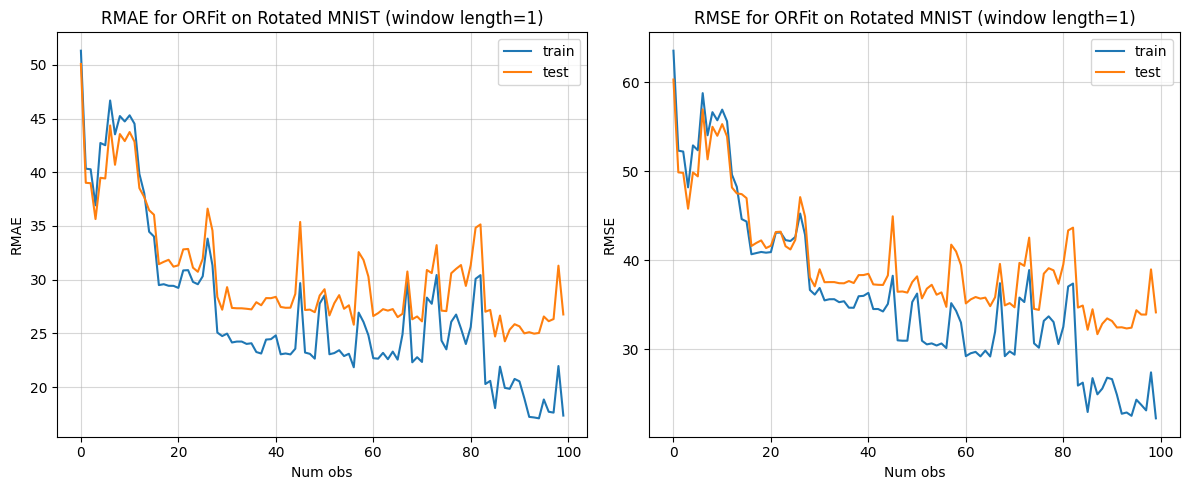

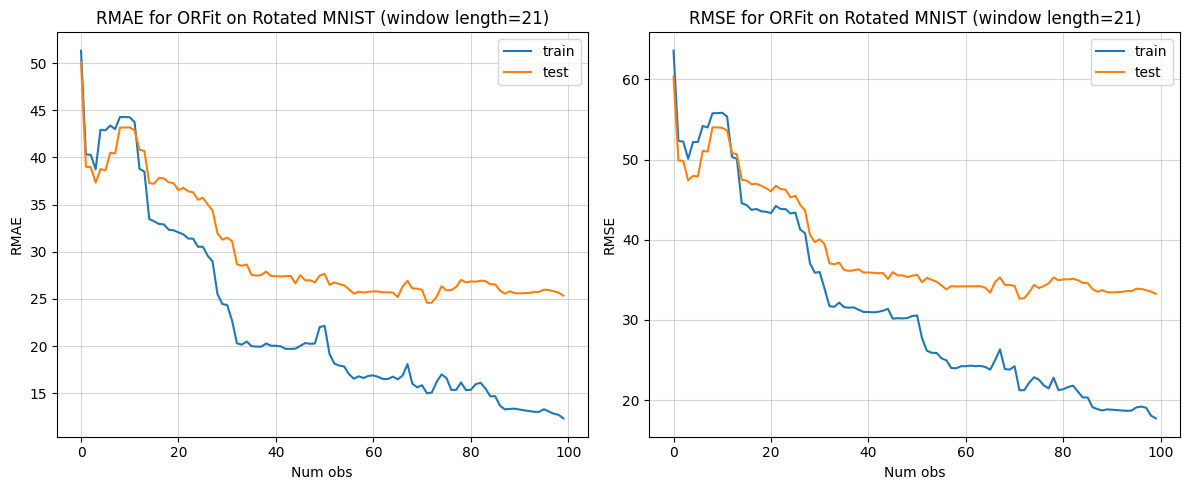

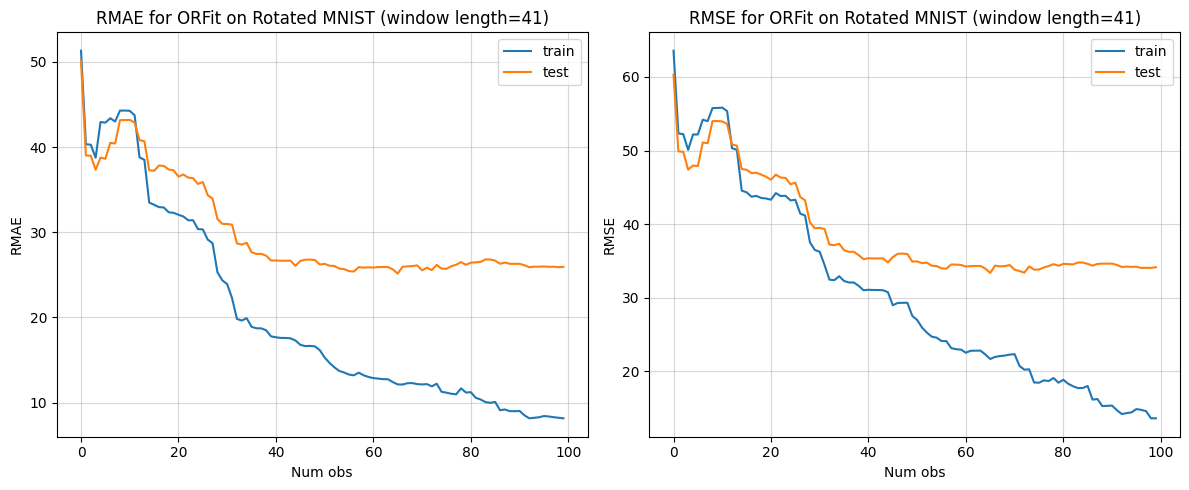

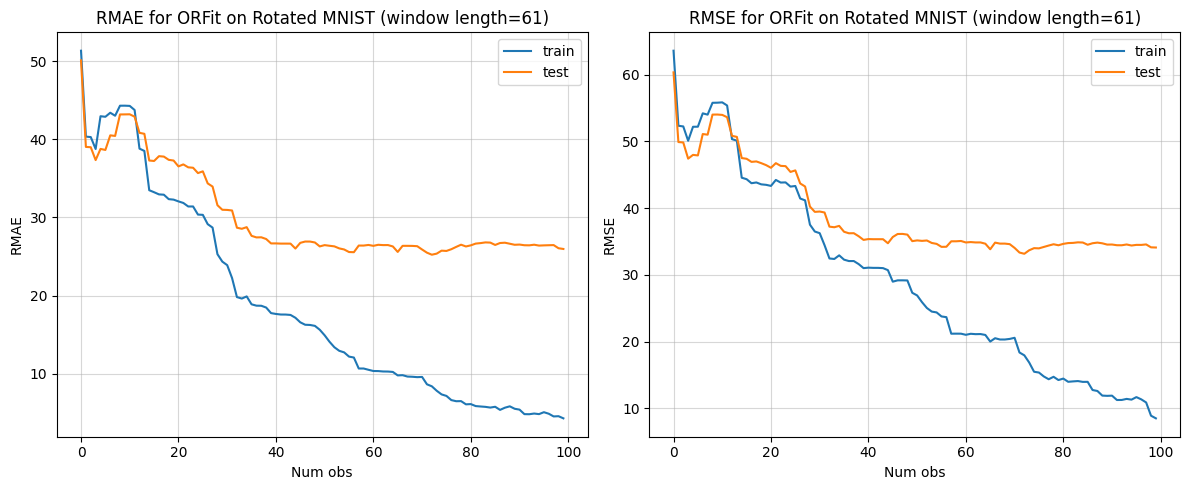

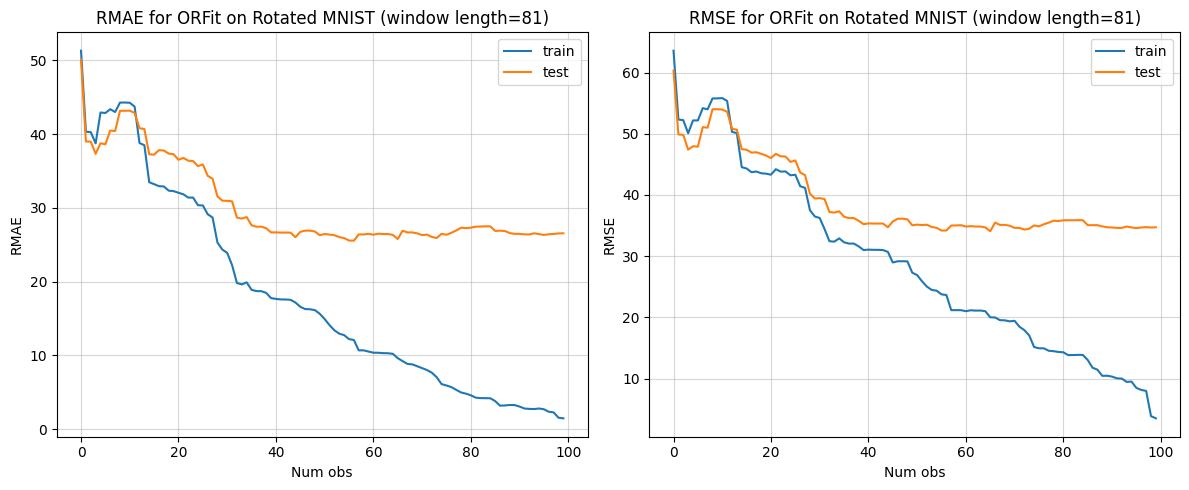

In [94]:
for win_len in tqdm(range(1, 101, 20)):
    # Run ORFit on rmnist dataset
    history_rmnist, _ = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train, y_train, win_len)

    # Predict on train and test set
    yhat_hist_train = vmap(apply_fn_rmnist, (0, None))(history_rmnist, X_train).squeeze()
    yhat_hist_test = vmap(apply_fn_rmnist, (0, None))(history_rmnist, X_test).squeeze()

    rmae_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
    rmae_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

    rmse_hist_test = jnp.sqrt(((yhat_hist_test - y_test[None, :])**2).mean(axis=-1))
    rmse_hist_train = jnp.sqrt(((yhat_hist_train - y_train[None, :])**2).mean(axis=-1))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(rmae_hist_train, label="train")
    ax1.plot(rmae_hist_test, label="test")
    ax1.legend()
    ax1.set_xlabel("Num obs")
    ax1.set_ylabel("RMAE")
    ax1.set_title(f"RMAE for ORFit on Rotated MNIST (window length={win_len})")
    ax1.grid(alpha=0.5)

    ax2.plot(rmse_hist_train, label="train")
    ax2.plot(rmse_hist_test, label="test")
    ax2.legend()
    ax2.set_xlabel("Num obs")
    ax2.set_ylabel("RMSE")
    ax2.set_title(f"RMSE for ORFit on Rotated MNIST (window length={win_len})")
    ax2.grid(alpha=0.5)

    plt.tight_layout()

In [159]:
# Sanity check:
# ORFit with memory size 100 on increasing-angle data should be the same as 
# ORFit with memory size 100 on random-angle data
fmp_inc_mean, fmp_inc_cov = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train_inc, y_train_inc, 100)
fmp_mean, fmp_cov = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train, y_train, 100)
assert jnp.allclose(fmp_inc_mean[-1], fmp_mean[-1], atol=1e-3)
assert jnp.allclose(fmp_inc_cov[-1], fmp_cov[-1], atol=1e-3)

In [70]:
# Run ORFit with memory size 10 on rmnist dataset
history_rmnist_ten_mem = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train, y_train, 10)
history_rmnist_ten_mem_inc = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train_inc, y_train_inc, 10)

# Run Infinite-memory ORFit on rmnist dataset
history_rmnist_inf_mem = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train, y_train, 100)

history_rmnist = {
    "Memory Size 10, Shuffled": history_rmnist_ten_mem,
    "Memory Size 10, Increasing": history_rmnist_ten_mem_inc,
    "Infinite Memory": history_rmnist_inf_mem,
}

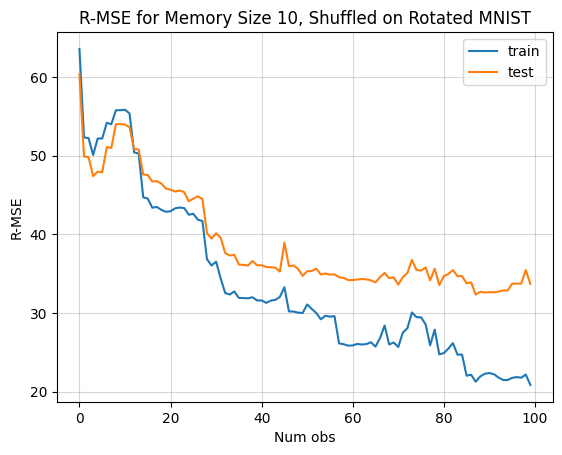

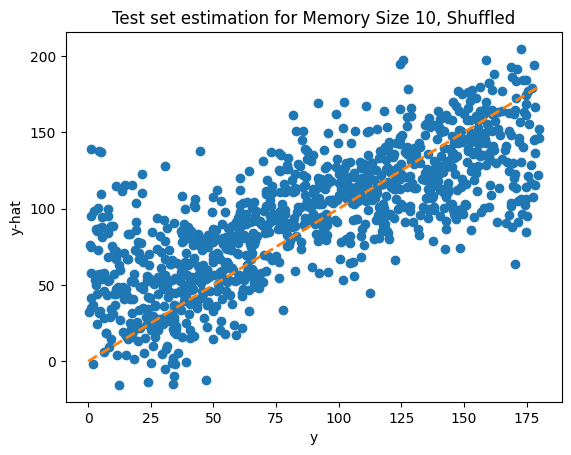

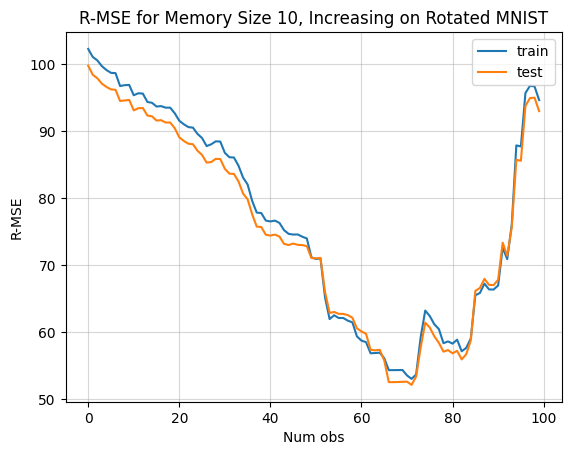

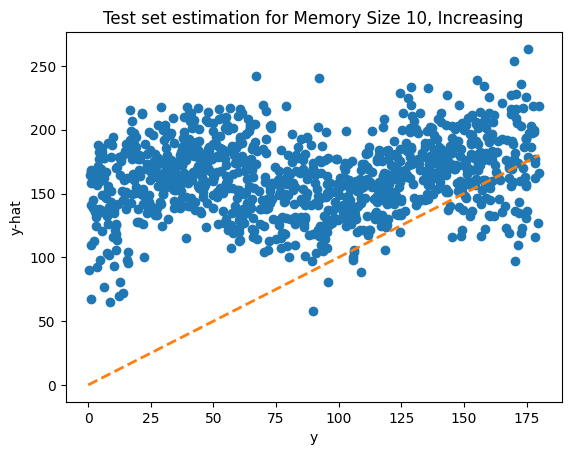

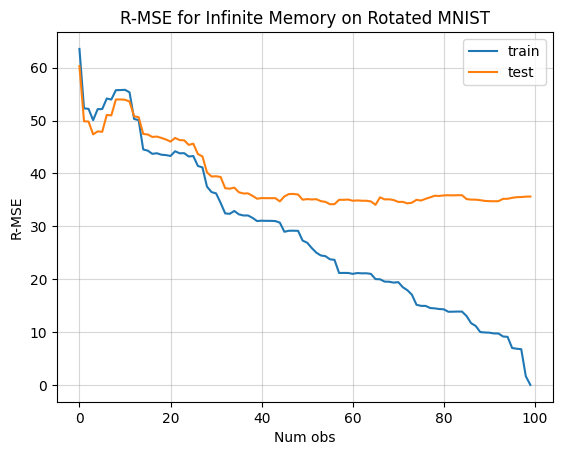

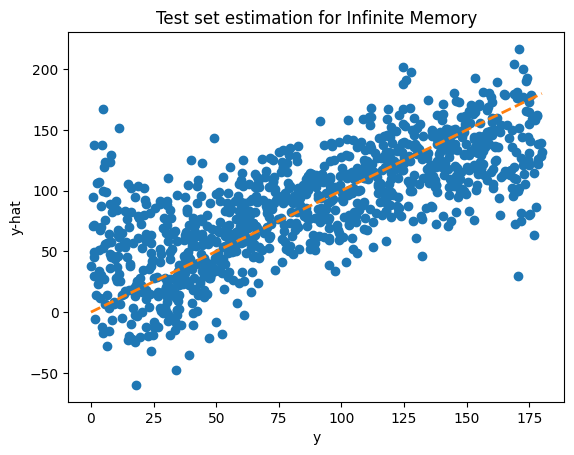

In [71]:
for name, history in history_rmnist.items():
    # Predict on train and test set
    yhat_hist_train = vmap(apply_fn_rmnist, (0, None))(history, X_train).squeeze()
    yhat_hist_test = vmap(apply_fn_rmnist, (0, None))(history, X_test).squeeze()

    rmae_hist_test = jnp.abs(yhat_hist_test - y_test[None, :]).mean(axis=-1)
    rmae_hist_train = jnp.abs(yhat_hist_train - y_train[None, :]).mean(axis=-1)

    rmse_hist_test = jnp.sqrt(((yhat_hist_test - y_test[None, :])**2).mean(axis=-1))
    rmse_hist_train = jnp.sqrt(((yhat_hist_train - y_train[None, :])**2).mean(axis=-1))

    fig, ax = plt.subplots()
    ax.plot(rmse_hist_train, label="train")
    ax.plot(rmse_hist_test, label="test")
    ax.legend()
    ax.set_xlabel("Num obs")
    ax.set_ylabel("R-MSE")
    ax.set_title(f"R-MSE for {name} on Rotated MNIST")
    plt.grid(alpha=0.5)

    yhat = apply_fn_rmnist(history[-1], X_test)
    fig, ax = plt.subplots()
    plt.scatter(y_test, yhat)
    plt.xlabel("y")
    plt.ylabel("y-hat")
    plt.plot([0,180], [0, 180], c="tab:orange", linestyle="--", linewidth=2)
    plt.title(f"Test set estimation for {name}");

## 4.2 Sample Prediction Error

Sample Prediction Error on the 16th example

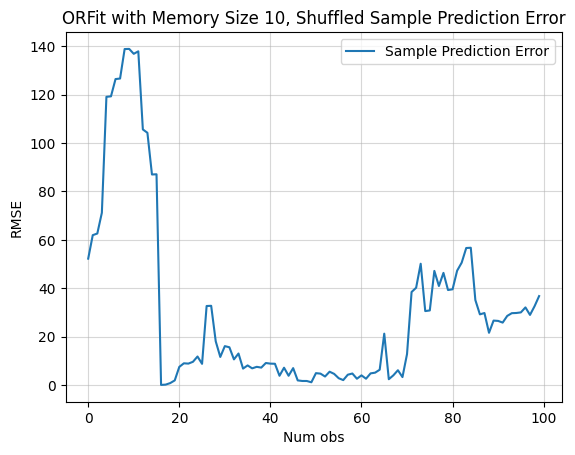

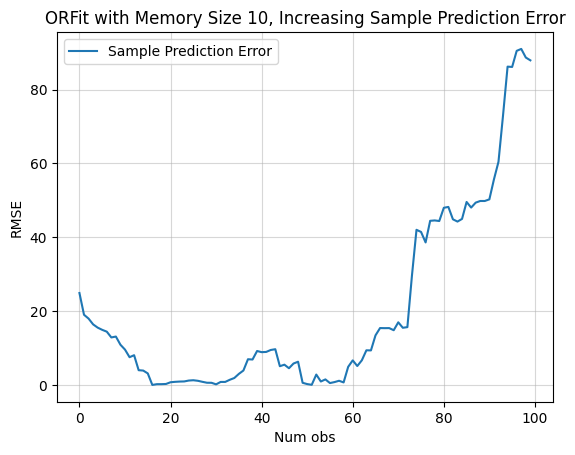

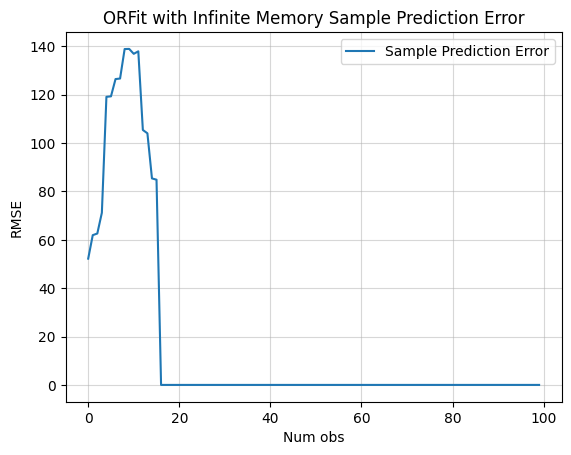

In [74]:
for name, history in history_rmnist.items():
    if name == "Memory Size 10, Increasing":
        yhats_sixteenth = vmap(apply_fn_rmnist, (0, None))(history, X_train_inc[16]).squeeze()
        err_hist_sixteenth = jnp.sqrt((yhats_sixteenth - y_train_inc[16])**2)
    else:
        yhats_sixteenth = vmap(apply_fn_rmnist, (0, None))(history, X_train[16]).squeeze()
        err_hist_sixteenth = jnp.sqrt((yhats_sixteenth - y_train[16])**2)

    fig, ax = plt.subplots()
    ax.plot(err_hist_sixteenth, label="Sample Prediction Error")
    ax.legend()
    ax.set_xlabel("Num obs")
    ax.set_ylabel("RMSE")
    ax.set_title(f"ORFit with {name} Sample Prediction Error")
    plt.grid(alpha=0.5)

## 4.3 Kalman Filter Comparison

In [91]:
# Define parameters for KF
cmgf_params = ParamsGGSSM(
    initial_mean=flat_params_rmnist,
    initial_covariance=jnp.eye(flat_params_rmnist.shape[0]),
    dynamics_function=lambda x, y: x,
    dynamics_covariance=jnp.eye(flat_params_rmnist.shape[0]) * 0.0,
    emission_mean_function=apply_fn_rmnist,
    emission_cov_function=lambda x, y: 0.0,
)

# Run KF
cmgf_posterior = conditional_moments_gaussian_filter(
    model_params=cmgf_params, 
    inf_params=EKFIntegrals(), 
    emissions=y_train, 
    inputs=X_train,
)

In [92]:
# Check that KF result matches that of full-memory ORFit
assert jnp.allclose(cmgf_posterior.filtered_means[-1], history_rmnist_inf_mem[-1], atol=1e-3)

## 4.4 Posterior Predictive

In [166]:
def posterior_predictive_moments(x_to_pred, post_mean, post_cov):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply_fn = lambda w: apply_fn_rmnist(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply_fn(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply_fn)(post_mean)
    pred_cov = F @ post_cov @ F.T

    return pred_mean, pred_cov

In [180]:
# Train on the first 20 observations
mean_20, cov_20 = orthogonal_recursive_fitting(flat_params_rmnist, apply_fn_rmnist, loss_fn_rmnist, X_train_inc[:20:2], y_train_inc[:20:2], 100)

In [181]:
def compute_covariance(x_to_pred, post_mean, post_cov):
    _, pred_cov = posterior_predictive_moments(x_to_pred, post_mean, post_cov)
    return pred_cov

In [182]:
covs = vmap(compute_covariance, (0, None, None))(X_train_inc, mean_20[-1], cov_20[-1]).ravel()

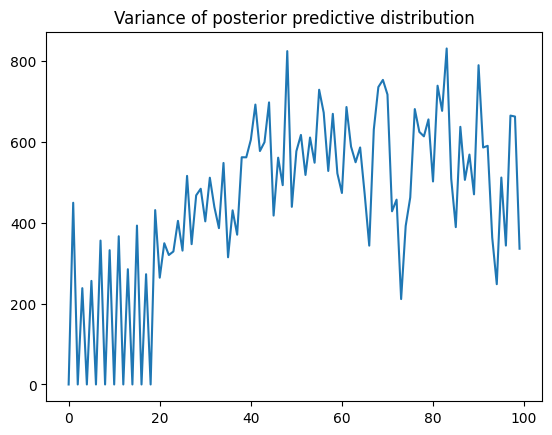

In [183]:
plt.plot(jnp.arange(100), covs);
plt.title("Variance of posterior predictive distribution");

In [168]:
posterior_predictive_moments(X_train_inc[0], mean_20[-1], cov_20[-1])

(Array([7.481107], dtype=float32), Array([[-0.00086596]], dtype=float32))